# Efficient Gaussian Random Field Inference on Graphs - Spectral Analysis

In this notebook, we study how the GRF converges to the PoFM matrices as the eigenvalues of the underlying laplacian matrix scales.

## Setup

In [1]:
import tensorflow as tf
import numpy as np
import scipy.special
import gpflow
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display, clear_output
import networkx as nx
from gpflow.utilities import print_summary
import tensorflow_probability as tfp
import seaborn as sns
from tqdm import tqdm

import sys
import os
project_root = os.path.abspath("../..")
sys.path.append(project_root)

from efficient_graph_gp.graph_kernels import get_normalized_laplacian
from efficient_graph_gp.gpflow_kernels import GraphDiffusionFastGRFKernel, GraphDiffusionPoFMKernel, GraphDiffusionKernel, GraphGeneralPoFMKernel, GraphGeneralFastGRFKernel
from utils import compute_fro
from traffic_utils.preprocessing import load_PEMS
from traffic_utils.plotting import plot_PEMS

In [2]:
# Load and preprocess the PEMS dataset

np.random.seed(1111)
num_eigenpairs = 500
dataset = 'PeMS-Bay-new'
num_train = 250

G, data_train, data_test, data = load_PEMS(num_train=num_train)
x_train, y_train = data_train
x_test, y_test = data_test
x, y = data
orig_mean, orig_std = np.mean(y_train), np.std(y_train)
y_train = (y_train-orig_mean)/orig_std
y_test = (y_test-orig_mean)/orig_std

X_train = tf.convert_to_tensor(x_train)
X_full = tf.convert_to_tensor(x)
Y_train = tf.convert_to_tensor(y_train)

adjacency_matrix = nx.to_numpy_array(G)  # Converts to NumPy adjacency matrix
print(adjacency_matrix.shape)  # Check matrix size

/Users/matthew/Documents/Efficient Gaussian Process on Graphs/Efficient_Gaussian_Process_On_Graphs/experiments/traffic_dataset/traffic_utils/preprocessing.py:90: UserWarning: Unpickling a shapely <2.0 geometry object. Please save the pickle again; shapely 2.1 will not have this compatibility.
  G = pickle.load(f)


epsg:4326
(1016, 1016)


/Users/matthew/Documents/Efficient Gaussian Process on Graphs/Efficient_Gaussian_Process_On_Graphs/venv/lib/python3.11/site-packages/osmnx/convert.py:381: FutureWarning: <class 'geopandas.array.GeometryArray'>._reduce will require a `keepdims` parameter in the future
  dupes = edges[mask].dropna(subset=["geometry"])


In [3]:
def gp_training(X,Y,X_new, graph_kernel):
    model = gpflow.models.GPR(data=(X, Y), kernel=graph_kernel, mean_function=None,noise_variance=0.01)
    
    # # Explicitly set dtype to float32
    # dtype = tf.float64
    # # Assign Uniform prior with explicitly cast float32 values
    # model.kernel.beta.prior = tfp.distributions.Uniform(
    #     low=tf.constant(0.0, dtype=dtype), 
    #     high=tf.constant(2.0, dtype=dtype)
    # )
    
    gpflow.optimizers.Scipy().minimize(model.training_loss, model.trainable_variables)
    mean, variance = model.predict_f(X_new)
    stddev = tf.sqrt(variance)
    return model, mean, stddev

def configure_model(model, hyperparameters):
    model.kernel.beta.assign(hyperparameters['beta'])
    model.kernel.sigma_f.assign(hyperparameters['sigma_f'])
    model.likelihood.variance.assign(hyperparameters['variance'])
    return model

def configure_model_general(model, hyperparameters):
    model.kernel.modulator_vector.assign(hyperparameters['modulator_vector'])
    model.likelihood.variance.assign(hyperparameters['variance'])
    return model

def gp_inference(model, X_new):
    mean, variance = model.predict_f(X_new)
    stddev = tf.sqrt(variance)
    return mean, stddev

def evaluate(model, x_test, y_test, quiet=False):
    
    train_likelihood = model.log_marginal_likelihood().numpy()
    
    mean, cov = model.predict_f(x_test, full_cov=True)
    l2_error = orig_std * np.linalg.norm(y_test.ravel() - mean.numpy().ravel()) / len(y_test.ravel())
    
    mean, cov = tf.reshape(mean, [-1]), cov[0]
    cov = cov + tf.linalg.diag(tf.fill([len(y_test)], model.likelihood.variance))
    dist = tfp.distributions.MultivariateNormalTriL(mean, cov)
    test_likelihood = dist.log_prob(tf.reshape(y_test, [-1])).numpy()
    
    if not quiet:
        print(f"Train likelihood: {train_likelihood}")
        print(f"L2 error: {l2_error}")
        print(f"Test likelihood: {test_likelihood}")
    
    return train_likelihood, l2_error, test_likelihood

## Experiments

In [5]:
MAX_WALK_LENGTH = 5

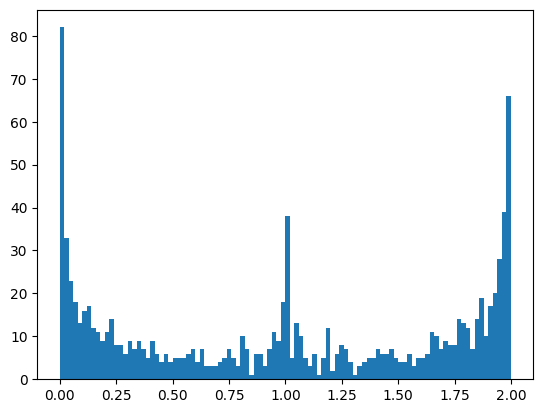

In [30]:
L = get_normalized_laplacian(adjacency_matrix)
eigenvalues, eigenvectors = tf.linalg.eigh(L)
eigenvalues = eigenvalues.numpy()
# print the distribution of eigenvalues
plt.hist(eigenvalues, bins=100)
plt.show()


In [28]:
eigenvalues.sort()
# check if there is any repeated eigenvalues
eigenvalues

array([1.90152575e-15, 1.26091901e-04, 1.56163302e-04, ...,
       1.99869934e+00, 1.99919817e+00, 1.99957601e+00])

In [18]:
# Define the range of beta values

# beta values are linearly spaced in log space from 0.001 to 10
beta_values = np.logspace(-3, 1, num=10)
walks_per_nodes = [1,2,4,8,16,32,64,128]

# Initialize a dictionary to store the results
grf_gram_matrices_dict = {}
pofm_gram_matrix_dict = {}

# Loop over each beta value
for beta in beta_values:
    
    pofm_kernel = GraphDiffusionPoFMKernel(adjacency_matrix,
                                       max_expansion=MAX_WALK_LENGTH,
                                       normalize_laplacian=True)
    gram_pofm = pofm_kernel.compute_diffusion_kernel(adjacency_matrix, beta, MAX_WALK_LENGTH)
    pofm_gram_matrix_dict[beta] = gram_pofm

    grf_gram_matrices = []
    for walks_per_node in tqdm(walks_per_nodes, desc=f'Walk lengths for beta={beta}'):
        # Create the graph kernel with the current walk length
        graph_kernel = GraphDiffusionFastGRFKernel(adjacency_matrix,
                                                   walks_per_node=walks_per_node,
                                                   p_halt=0.1,
                                                   max_walk_length=MAX_WALK_LENGTH+1,
                                                   normalize_laplacian=True)
        grf_gram_matrices.append(graph_kernel.grf_kernel(beta=beta, sigma_f=1))
    grf_gram_matrices_dict[beta] = grf_gram_matrices

Walk lengths for beta=10.0: 100%|██████████| 8/8 [00:11<00:00,  1.44s/it]


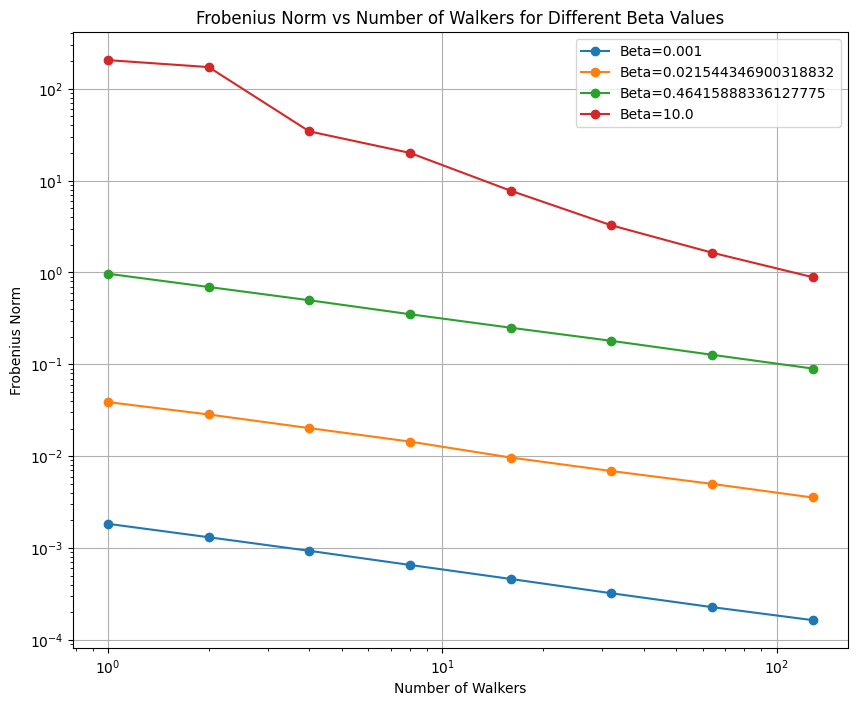

In [19]:
# Plot Frobenius norm vs. Number of Walkers for each beta value
plt.figure(figsize=(10, 8))

for beta in beta_values[::3]:
    frobenius_norms = [compute_fro(pofm_gram_matrix_dict[beta], grf_gram) for grf_gram in grf_gram_matrices_dict[beta]]
    plt.plot(walks_per_nodes, frobenius_norms, marker='o', linestyle='-', label=f'Beta={beta}')

plt.xlabel('Number of Walkers')
plt.xscale('log')
plt.ylabel('Frobenius Norm')
plt.yscale('log')
plt.title('Frobenius Norm vs Number of Walkers for Different Beta Values')
plt.legend()
plt.grid(True)
plt.show()

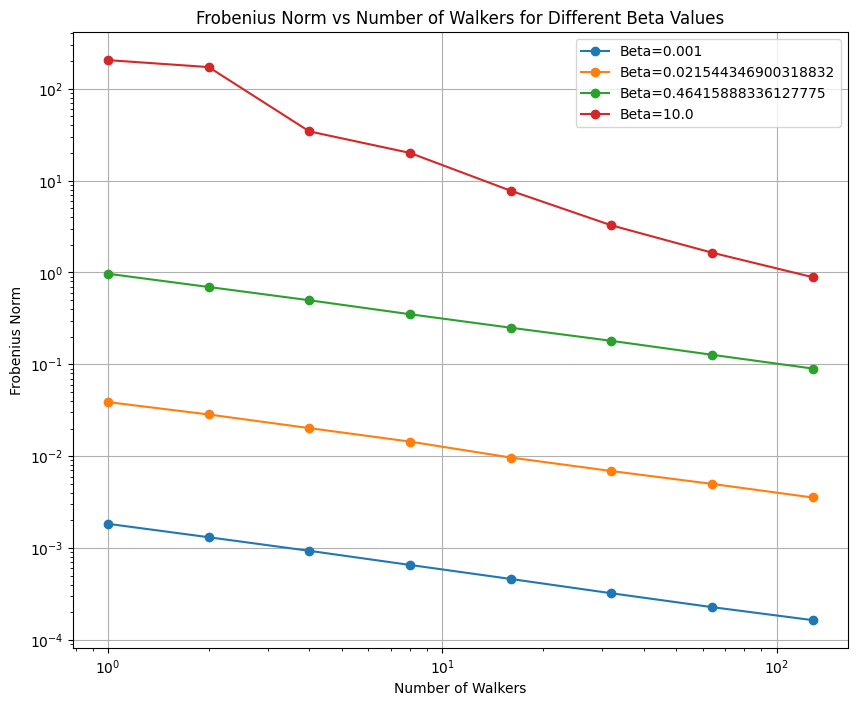

Exponent for Beta 0.001: -0.5015
Exponent for Beta 0.021544346900318832: -0.4991
Exponent for Beta 0.46415888336127775: -0.4897
Exponent for Beta 10.0: -1.1909


In [40]:
import numpy as np
import matplotlib.pyplot as plt

# Plot Frobenius norm vs. Number of Walkers for each beta value
plt.figure(figsize=(10, 8))

slopes_dict = {}

for beta in beta_values[::3]:
    frobenius_norms = [compute_fro(pofm_gram_matrix_dict[beta], grf_gram) for grf_gram in grf_gram_matrices_dict[beta]]

    # Convert to log-log domain
    log_walks = np.log(walks_per_nodes)
    log_frobenius_norms = np.log(frobenius_norms)

    # Perform a linear fit (log Frobenius Norm vs log Walks per Node)
    slope, intercept = np.polyfit(log_walks, log_frobenius_norms, 1)
    slopes_dict[beta] = slope  # Store slope for later use

    # Plot Frobenius Norm vs Walks per Node
    plt.plot(walks_per_nodes, frobenius_norms, marker='o', linestyle='-', label=f'Beta={beta}')

plt.xlabel('Number of Walkers')
plt.xscale('log')
plt.ylabel('Frobenius Norm')
plt.yscale('log')
plt.title('Frobenius Norm vs Number of Walkers for Different Beta Values')
plt.legend()
plt.grid(True)
plt.show()

# Print slopes (exponents in the log-log scale)
for beta, slope in slopes_dict.items():
    print(f'Exponent for Beta {beta}: {slope:.4f}')


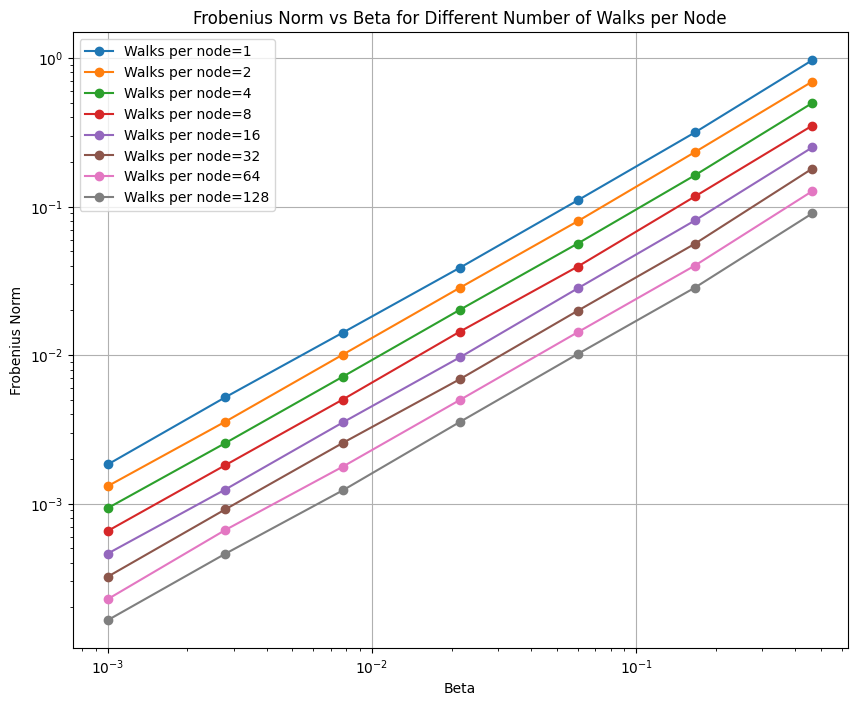

Exponent for Walks per Node 1: 1.0144
Exponent for Walks per Node 2: 1.0207
Exponent for Walks per Node 4: 1.0194
Exponent for Walks per Node 8: 1.0206
Exponent for Walks per Node 16: 1.0230
Exponent for Walks per Node 32: 1.0214
Exponent for Walks per Node 64: 1.0211
Exponent for Walks per Node 128: 1.0220


In [39]:
# Truncate beta values for analysis
beta_values_trunc = beta_values[0:-3]

# Plot Frobenius norm vs. Beta for each number of random walks per node
plt.figure(figsize=(10, 8))

slopes_dict = {}

for walks_per_node in walks_per_nodes:
    frobenius_norms = [compute_fro(pofm_gram_matrix_dict[beta], grf_gram_matrices_dict[beta][walks_per_nodes.index(walks_per_node)]) for beta in beta_values_trunc]

    # Convert to log-log domain
    log_beta = np.log(beta_values_trunc)
    log_frobenius_norms = np.log(frobenius_norms)

    # Perform a linear fit (log Frobenius Norm vs log Beta)
    slope, intercept = np.polyfit(log_beta, log_frobenius_norms, 1)
    slopes_dict[walks_per_node] = slope  # Store slope for later use

    # Plot Frobenius Norm vs Beta
    plt.plot(beta_values_trunc, frobenius_norms, marker='o', linestyle='-', label=f'Walks per node={walks_per_node}')

plt.xlabel('Beta')
plt.xscale('log')
plt.ylabel('Frobenius Norm')
plt.yscale('log')
plt.title('Frobenius Norm vs Beta for Different Number of Walks per Node')
plt.legend()
plt.grid(True)
plt.show()

# Print slopes (exponents in the log-log scale)
for walks_per_node, slope in slopes_dict.items():
    print(f'Exponent for Walks per Node {walks_per_node}: {slope:.4f}')
